# implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
class kohonen:

    def __init__(self, M, N, X):
        self.M = M
        self.N = N
        self.input_dim = X.shape[1]
        minimum = np.min(X, axis=0)
        maximum = np.max(X, axis=0)
        self.weights = np.random.uniform(0, 1, (self.input_dim, M, N))
        for i in range(self.input_dim):
            self.weights[i] = minimum[i] + (maximum[i] - minimum[i]) * self.weights[i]

    def gauss_neighbourhood(self, t, T):
        return np.exp(-t / T)

    def mexican_hat_neighbourhood(self, t, T):
        return np.exp(-t / T) * (1 - 2 * t / T)

In [52]:
X = pd.DataFrame(np.random.uniform(-1, 4, (4, 2)), columns=["x", "y"]).to_numpy()

In [55]:
koch = kohonen(100, 10, X)

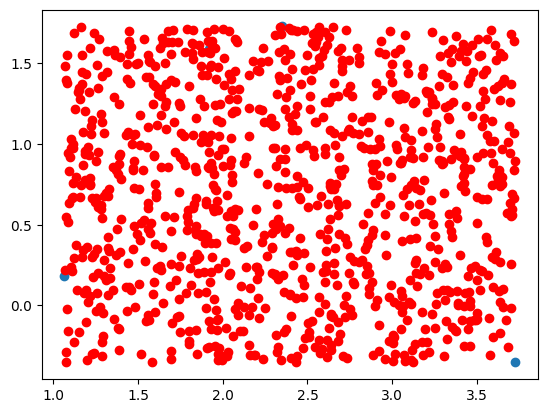

In [56]:
# plot scater plot of x
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(koch.weights[0], koch.weights[1], c="red")